# ALeRCE supernova starter notebook, for new DB

```Author: Francisco Förster, Last updated: 20200804```

ALeRCE starter notebook for supernova science using the new alerce client, API, and a direct database connection.

For more information about the ALeRCE broker, please visit http://alerce.science/

Note that this notebook uses the experimental ALeRCE API, which can be cloned and installed (`pip install -e .`) from https://github.com/alercebroker/alerce_client_new

Pending issues:

* `SPM_beta` and `SPM_gamma` in `feature` are inverted
* `SPM_A` in `feature` should be multiplied by 1e-26 to recover its value in cgs. This is OK, but should be explained somewhere.

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Table of contents:
* [Introduction](#intro)
* [Requirements](#req)
* [ALeRCE client](#client)
* [Simple functions to plot light curves](#simplefunctions)
* [Advanced plotting functions including dust and distance attenuation corrections](#advancedfunctions)
* [Using Aladin to select the host galaxy](#host)
* [Query many SNe candidates using the client](#sneiaclient)
* [Query many SNe candidates using a direct DB connection](#sneiadb)

# Introduction <a class="anchor" id="intro"></a>

In this notebook we will query data from a single supernova in order to plot its apparent magnitude and absolute magnitude light curve, applying Milky Way dust attenuation corrections as well. We will also see its image stamp, and visualize the host galaxy to make sure the redshift used is correct.

Then, we will query many supernova using the ALeRCE client, showing the distribution of peak magnitudes and dust attenuations.

Finally, we will repeat this calculation for a much larger sample size connecting directly to the ALeRCE database.

Más información paper

# Requirements <a class="anchor" id="req"></a>

Basic requirements

In [2]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Astropy

In [3]:
import astropy.units as u
from astropy import coordinates
from astropy.time import Time
from astropy.table import Table, Column
from astropy.coordinates import Distance
from astropy.cosmology import WMAP7

Install and import pyaladin https://github.com/cds-astro/ipyaladin

In [4]:
# you may need to restart the notebook after running the following lines
#!pip install ipyaladin
#!jupyter nbextension enable --py widgetsnbextension
#!jupyter nbextension enable --py --sys-prefix ipyaladin

In [5]:
import ipyaladin as ipyal # see installation instructions here: https://github.com/cds-astro/ipyaladin

Astroquery https://astroquery.readthedocs.io/en/latest/

In [6]:
#!pip install astroquery
from astroquery.ned import Ned
from astroquery.irsa_dust import IrsaDust

Other

In [7]:
from IPython.display import HTML
from ipywidgets import Layout, Box, widgets

# ALeRCE client <a class="anchor" id="client"></a>

Install and import the new alerce API client https://github.com/alercebroker/alerce_client_new

Clone and `pip install -e .`

In [8]:
from alerce.core import Alerce
client = Alerce()

In [9]:
# color blind friendly green and red 
colors = {1: '#56E03A', 2: '#D42F4B'} 

# Simple functions to plot light curves  <a class="anchor" id="simplefunctions"></a>

We will create a simple function that plots the light curve given an object id (oid), a dataframe with detections and a dataframe with non detections. We will first define manually the oid which we want to explore (we select a SN Ia with a known host redshift in NED for test purposes, we will later do queries for a collection of SNe).

In [10]:
seloid = "ZTF18acpfwmm"

In [11]:
def plotLC(oid, SN_det, SN_nondet):
    
    fig, ax = plt.subplots(figsize = (14, 7))
    labels = {1: 'g', 2: 'r'}
    markers = {1: 'o', 2: 's'}
    sizes = {1: 30, 2: 60}
    
    # loop the passbands
    for fid in [1, 2]:
        
        # plot detections if available
        mask = SN_det.fid == fid
        if np.sum(mask) > 0:
            # note that the detections index is candid and that we are plotting the psf corrected magnitudes
            ax.errorbar(SN_det[mask].mjd, SN_det[mask].magpsf, 
                yerr = SN_det[mask].sigmapsf, c=colors[fid], label=labels[fid], marker=markers[fid])
        
        # plot non detections if available
        mask = (SN_nondet.fid == fid) & (SN_nondet.diffmaglim > -900)
        if np.sum(mask) > 0:     
            # non detections index is mjd
            ax.scatter(SN_nondet[mask].mjd, SN_nondet[mask].diffmaglim, c=colors[fid], alpha = 0.5,
                marker='v', label="lim.mag. %s" % labels[fid], s=sizes[fid])
            
    ax.set_title(oid)
    ax.set_xlabel("MJD")
    ax.set_ylabel("Apparent magnitude")
    ax.legend()
    ax.set_ylim(ax.get_ylim()[::-1])

Then, we will create a function that only gets the light curve (LC) data and plots it if required, the results are then returned to the user as a dictionary. Note that we use the client to query the detections and non detections and that we return the results in pandas format (default is votable).

In [12]:
def getSNdata(oid, doLC=False):

    results = {"oid": oid}
        
    # query detections
    SN_det = client.query_detections(oid, format='pandas')
    SN_det = SN_det.sort_values("mjd")
    results["lc_det"] = SN_det
        
    # query non detections
    SN_nondet = client.query_non_detections(oid, format='pandas')
    SN_nondet = SN_nondet.sort_values("mjd")
    results["lc_nondet"] = SN_nondet
    
    # plot the LC
    if doLC:
        plotLC(oid, SN_det, SN_nondet)
        
    # return data
    return results

And now we can show the object's light curve

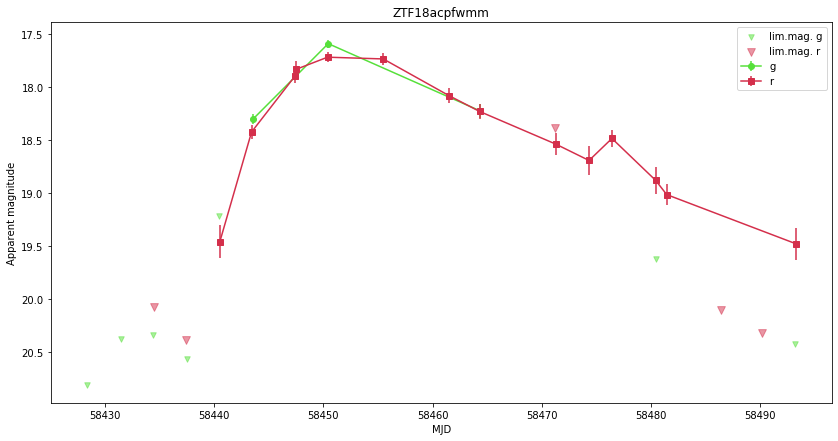

In [13]:
results = getSNdata(seloid, doLC=True)

You can see the detections and non detections in g and r bands. The SN shows a secondary r band bump, which is characteristic of normal SNe Ia.

# Advanced plotting functions including dust and distance attenuation corrections  <a class="anchor" id="advancedfunctions"></a>

We will modify our previous function and now we will be able to receive a dictionary with attenuations due to Galactic extinction, as well as the redshift. This will allow us to get absolute magnitudes (assuming no K-corrections) in restframe days. Note that we use astroquery Distance and WMAP7 objects, as well as mag units.

In [14]:
def plotLC(oid, SN_det, SN_nondet, A=None, redshift=None):
    
    fig, ax = plt.subplots(figsize = (14, 7))
    labels = {1: 'g', 2: 'r'}
    markers = {1: 'o', 2: 's'}
    sizes = {1: 30, 2: 60}
    
    # distmod: distance modulus, reftime: reference time
    if redshift is not None:
        distmod = float(Distance(z=redshift, cosmology=WMAP7).distmod / u.mag)
        reftime = SN_det.mjd.min()
    else:
        distmod = 0
        reftime = 0
        redshift = 0
        
    # loop the passbands
    for fid in [1, 2]:
        
        # galactic extinction in the given band
        if A is not None:
            A_fid = A[labels[fid]]
        else:
            A_fid = 0

        # plot detections if available
        mask = SN_det.fid == fid
        if np.sum(mask) > 0:
            
            # change time to restframe days if redshift is not zero
            times = (SN_det[mask].mjd - reftime) / (1. + redshift)
            
            # note that the detections index is candid and that we are plotting the psf corrected magnitudes
            if A_fid != 0:
                # plot attenuated light curve with small alpha
                ax.errorbar(times, SN_det[mask].magpsf - distmod, 
                    yerr=SN_det[mask].sigmapsf, c=colors[fid], marker=markers[fid], label=labels[fid], alpha=0.1)
                # show dust and distance attenuation corrected light curve
                ax.errorbar(times, SN_det[mask].magpsf - A_fid - distmod, 
                    yerr=SN_det[mask].sigmapsf, c=colors[fid], marker=markers[fid], label="%s (ext. corr.)" % labels[fid])
            else:
                # correct only for redshift
                ax.errorbar(times, SN_det[mask].magpsf - distmod, 
                    yerr=SN_det[mask].sigmapsf, c=colors[fid], marker=markers[fid], label=labels[fid])
        
        # plot non detections if available (and correct for dust and distance attenuation)
        mask = (SN_nondet.fid == fid) & (SN_nondet.diffmaglim > -900)
        if np.sum(mask) > 0:     
            times = (SN_nondet[mask].mjd - reftime) / (1. + redshift)
            # non detections index is mjd
            ax.scatter(times, SN_nondet[mask].diffmaglim - A_fid - distmod, c = colors[fid], alpha = 0.5,
                marker='v', label="lim.mag. %s" % labels[fid], s=sizes[fid])
            
    # labels
    if A is not None and redshift != 0:
        ax.set_title("%s ($A_g=%.3f, A_r=%.3f$, z=%.4f)" % (oid, A["g"], A["r"], redshift))
    elif redshift != 0:
        ax.set_title("%s (z=%.4f)" % (oid, redshift))
    elif A is not None:
        ax.set_title("%s ($A_g=%.3f, A_r=%.3f$)" % (oid, A["g"], A["r"]))
    else:
        ax.set_title(oid)
        
    if redshift == 0:
        ax.set_xlabel("MJD")
        ax.set_ylabel("Apparent magnitude")
    else:
        ax.set_xlabel("Restframe time [days]")
        ax.set_ylabel("Absolute magnitude (no K-corr.)")
    ax.legend()
    ax.set_ylim(ax.get_ylim()[::-1])

We will also modify the getSNdata function to get all the necessary information given the object id (oid). It now does the following:
 - display a link to the ALeRCE explorer page for this SN
 - get the basic SN statistics, this includes the position in the sky (using the ALeRCE client)
 - get the detections and non detections (using the ALeRCE client)
 - get the Milky Way dust attenuation at the given position in the sky (using astroquery IrsaDust)
 - plot the apparent magnitude LC corrected for dust attenuation (using the previously defined function)
 - query NED for galaxies with known redshifts (using astroquery Ned), assuming that the nearest galaxy's redshift is the same as the SN.
 - plot the absolute magnitude LC correction for Milky Way dust and distance attenuation, in restframe time and ignoring k-corrections (using the previously defined plotLC function)
 - plot the first image stamps associated to this SN (using the ALeRCE client)

In [15]:
def getSNdata(oid, doLC=False, doext=False, dostamp=False, doNED=False, doredshift=False):

    results = {"oid": oid}
    
    # query basic stats
    SN_stats = client.query_object(oid, format='pandas')
    results["stats"] = SN_stats
    
    # query detections
    SN_det = client.query_detections(oid, format='pandas')
    SN_det = SN_det.sort_values("mjd")
    results["lc_det"] = SN_det
        
    # query non detections
    SN_nondet = client.query_non_detections(oid, format='pandas')
    SN_nondet = SN_nondet.sort_values("mjd")
    results["lc_nondet"] = SN_nondet
    
    # object coordinates
    co = coordinates.SkyCoord(ra=float(SN_stats.meanra), dec=float(SN_stats.meandec), unit=(u.deg, u.deg), frame='icrs')
    
    # get galactic extinction
    if doext:
        # Galactic extinction (use SFD = D.J. Schlegel, D.P. Finkbeiner, & M. Davis (1998, ApJ, 500, 525))
        table = IrsaDust.get_extinction_table(co)
        A = {"g": float(table[table["Filter_name"] == "SDSS g"]["A_SFD"]), "r": float(table[table["Filter_name"] == "SDSS r"]["A_SFD"])}
        results["attenuation"] = A
    else:
        A = {"g": 0, "r": 0}

    # plot the LC
    if doLC:
        if doext:
            plotLC(oid, SN_det, SN_nondet, A)
        else:
            plotLC(oid, SN_det, SN_nondet)
            
    # find NED galaxies
    if doNED:
        Ned_table = Ned.query_region(co, radius=0.01 * u.deg, equinox='J2000.0')
        display(Ned_table)
        results["ned_table"] = Ned_table
        
        # save closest redshift if any
        df_ned = Ned_table.to_pandas()
        mask=df_ned.Redshift.notna()
        if mask.sum() > 0:
            results["redshift"] = df_ned.loc[df_ned.loc[mask].Separation.idxmin()].Redshift
            print("Redshift found: %s" % results["redshift"])
            
    # plot absolute value (without K-corrections)
    if doredshift:
        if type(doredshift) == float and doredshift > 0:
            results["redshift"] = doredshift
        if "redshift" in results.keys():
            if doext:
                plotLC(oid, SN_det, SN_nondet, A, results["redshift"])
            else:
                plotLC(oid, SN_det, SN_nondet, results["redshift"])            
    
    
    # show link
    display(HTML("<a href='http://alerce.online/object/%s' target=\"_blank\"> %s <a>" % (oid, oid)))
    
    # show the first image stamp
    if dostamp:
        candid = results["lc_det"].loc[results["lc_det"].has_stamp].candid.min()
        stamps = client.get_stamps(oid, candid)
        science, ref, difference = stamps[0].data, stamps[1].data, stamps[2].data
        fig, ax = plt.subplots(ncols=3, figsize=(12, 6))
        for idx, im in enumerate([np.log(science), np.log(ref), difference]):
            ax[idx].imshow(im, cmap='viridis') # Log scale for visualization
            ax[idx].axes.get_xaxis().set_visible(False)
            ax[idx].axes.get_yaxis().set_visible(False)
        ax[0].set_title("oid: %s, candid: %s (science, reference and difference)" % (oid, candid), loc='left')
        fig.subplots_adjust(wspace = 0, hspace = 0)
        
    # return data
    return results

Now we test these functions with the same SN as before. We selected a SN with a known spectrocopic redshift, but this is usually not the case.

No.,Object Name,RA,DEC,Type,Velocity,Redshift,Redshift Flag,Magnitude and Filter,Separation,References,Notes,Photometry Points,Positions,Redshift Points,Diameter Points,Associations
,,degrees,degrees,,km / s,,,,arcmin,,,,,,,
int32,bytes30,float64,float64,object,float64,float64,object,object,float64,int32,int32,int32,int32,int32,int32,int32
1,WISEA J073109.69+534143.6,112.79039,53.69547,IrS,--,--,,,0.455,0,0,12,1,0,0,0
2,WISEA J073112.05+534203.2,112.79992,53.70097,G,--,--,,,0.185,0,0,27,3,0,2,0
3,WISEA J073112.21+534221.9,112.80091,53.70609,IrS,--,--,,,0.474,0,0,12,1,0,0,0
4,SN 2018iui,112.80233,53.69821,SN,--,--,,,0.001,1,0,0,1,0,0,0
5,WISEA J073112.64+534152.3,112.80271,53.69786,G,14781.0,0.049304,,,0.026,1,0,27,3,0,2,0
6,WISEA J073113.74+534201.8,112.80727,53.70051,IrS,--,--,,,0.223,0,0,12,1,0,0,0
7,WISEA J073115.75+534132.2,112.81565,53.69228,IrS,--,--,,,0.593,0,0,12,1,0,0,0


Redshift found: 0.049304


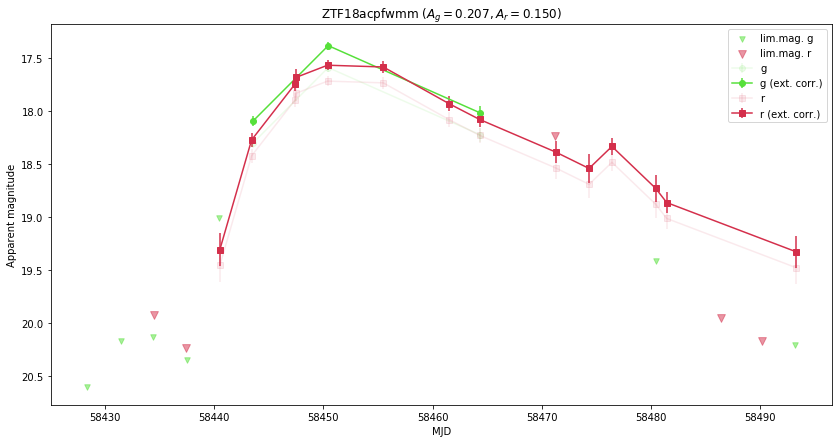

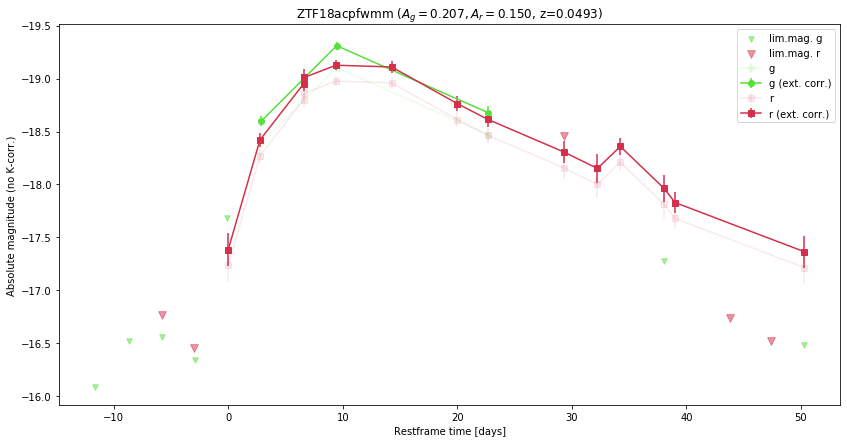

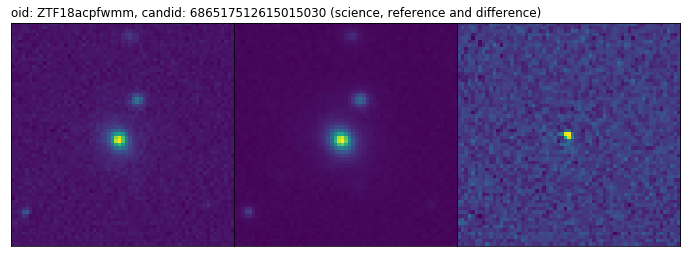

In [16]:
results = getSNdata(seloid, doLC=True, doext=True, dostamp=True, doNED=True, doredshift=True);

The supernova peaks around -19 magnitudes, which is typical for SNe Ia.

You can also force the absolute magnitude plot by giving the redshift manually. This may be necessary if there is not a redshift in NED or you need to use a much larger search radius to find it automatically, e.g.

No.,Object Name,RA,DEC,Type,Velocity,Redshift,Redshift Flag,Magnitude and Filter,Separation,References,Notes,Photometry Points,Positions,Redshift Points,Diameter Points,Associations
,,degrees,degrees,,km / s,,,,arcmin,,,,,,,
int32,bytes30,float64,float64,object,float64,float64,object,object,float64,int32,int32,int32,int32,int32,int32,int32
1,NGC 4321:[HK83] 204,185.71916,15.82656,HII,--,--,,,0.588,1,0,0,1,0,0,0
2,NGC 4321:[HK83] 193,185.72174,15.8274,HII,--,--,,,0.47,1,0,0,1,0,0,0
3,NGC 4321:[HK83] 189,185.72261,15.82017,HII,--,--,,,0.416,1,0,0,1,0,0,0
4,SSTSL2 J122253.73+154953.9,185.72388,15.83164,IrS,--,--,,,0.561,0,0,8,1,0,0,0
5,NGC 4321:[HK83] 181,185.72436,15.81768,HII,--,--,,,0.441,1,0,0,1,0,0,0
6,SSTSL2 J122254.00+154954.5,185.72504,15.83181,IrS,--,--,,,0.539,0,0,10,1,0,0,0
7,NGC 4321:[HK83] 177,185.72523,15.82712,HII,--,--,,,0.297,1,0,0,1,0,0,0
8,CXO J122254.1+154912,185.72552,15.82016,XrayS,--,--,,,0.283,7,0,2,2,0,0,0


Redshift found: 0.00524


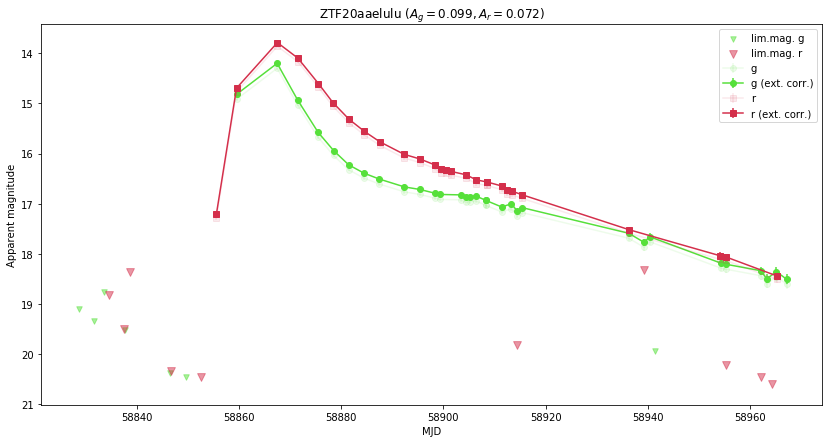

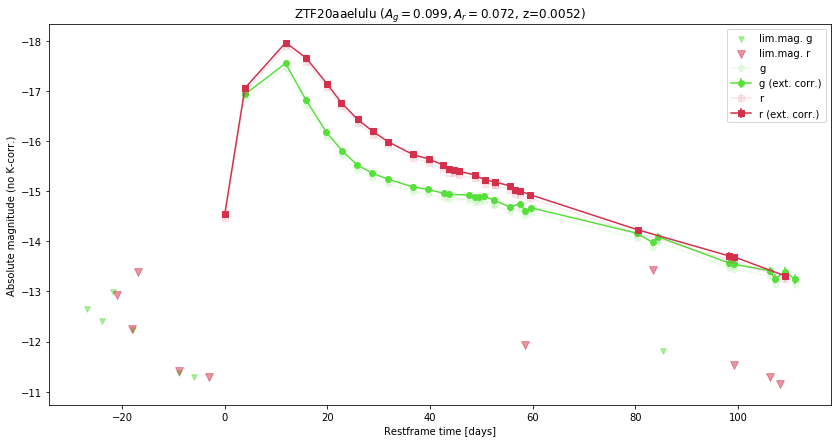

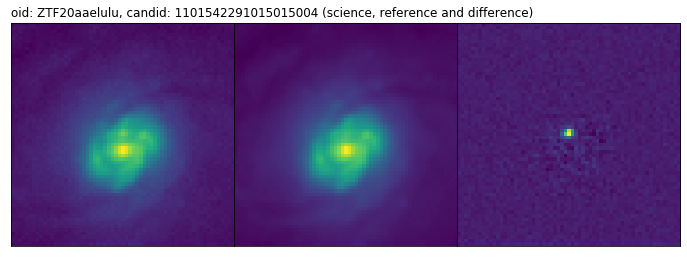

In [17]:
results = getSNdata("ZTF20aaelulu", doLC=True, doext=True, dostamp=True, doNED=True, doredshift=True);

# Using Aladin to select the host galaxy from NED  <a class="anchor" id="host"></a>

With these two functions you should be able to hover over the NED sources near the SNe and see whether NED has a registered redshift. This can be used as a sanity check.

In [18]:
info = widgets.HTML()

def process_objectHovered(data):
    
    output = '<font color="red">'
    # NED
    if data["data"]["cat_name"] == "Ned":
        output = "<h2>NED</h2>"
        sel_keys = ["Object Name", "Separation", "RA", "DEC", "Type", "Redshift", "Redshift Flag", "Magnitude and Filter"]
    for key in sel_keys:
        if key in data["data"].keys():
            output += "<p><font size='1'>%s: %s</p>" % (key, data["data"][key])
    info.value =  '%s' % output

In [19]:
def show_host(results):
    aladin= ipyal.Aladin(target='%s %s' % (float(results["stats"].meanra), float(results["stats"].meandec)), 
                fov=0.04, survey='P/PanSTARRS/DR1/color-z-zg-g',
                reticle_size= 64,
                layout=Layout(width='70%'))
    box_layout = Layout(display='flex', flex_flow='row', align_items='stretch', width='100%')
    box = Box(children=[aladin, info], layout=box_layout)
    display(box)
    if "ned_table" in results:
        results["ned_table"]["cat_name"] = Column(["Ned"], name="cat_name")
        aladin.add_table(results["ned_table"])
    aladin.add_listener('objectHovered', process_objectHovered)
    print("Hover mouse to see information about catalog objects")

In [20]:
show_host(results)

Box(children=(Aladin(fov=0.04, layout=Layout(width='70%'), options=['allow_full_zoomout', 'coo_frame', 'fov', …

Hover mouse to see information about catalog objects


If you hover over the galaxy's NED reported position, some 6" below the candidate, you can confirm that the redshift 0.00524 for ZT20aaelulu is correct.

Can you expand this notebook to get photometric redshifts from SDSS?

# Query many SN Ia candidates using the client <a class="anchor" id="sneiaclient"></a>

The ALeRCE client allows users to access the ALeRCE API and do simple queries to our database. You can get information about each command using the help command.

### Classifiers, taxonomies and numeric mappings

There are two classifiers used in ALeRCE:

1. A stamp based classifier (Carrasco-Davis et al. 2020), which classifies objects based on their first image stamps. The purpose of this classifier is to trigger alerts for young SN candidates and other objects.
2. A light curve based classifier (Sánchez-Sáez et al. 2020), which classifies objects based on their light curve. The purpose of this classifier is to provide a more refined classification starting with at least 6 detections in a given band.

Each classifier has its own taxonomy, which is more refined for the light curve classifier. 

The stamp classifier contains the following classes:
* `agn`
* `sn`
* `vs`
* `asteroid`
* `bogus`
    
The late classifier uses the light curve information and contains the following classes:

* `SNIa`
* `SNIbc`
* `SNII`
* `SLSN`
* `QSO`
* `AGN`
* `Blazar`
* `CV/Nova`
* `YSO`
* `DSCT`
* `CEP`
* `LPV`
* `RRL`
* `E`
* `Periodic-Other`

The taxonomy from the light curve classifier is shown below:
![Taxonomy](figures/taxonomy_tree.png)


The light curve classifier classification is explained in detail in Sánchez-Saéz et al. 2020. Its confusion matrix is shown below:

![SanchezSaez+2020](figures/SanchezSaez+2020_confusion.png)

The recall as a function of magnitude is shown below (note the SN are grouped in this figure)
![SanchezSaez+2020](figures/SanchezSaez+2020_recall.png)

We will now query the top 1000 SN Ia candidates which exploded at least 70 days after ZTF's 1st light, that have a probability > 0.4 of being a SNe Ia according to the light curve classifier, and which have between 10 and 50 detections. We will output the result of the query directly as a pandas dataframe.

In [21]:
min_firstmjd = Time("2017-11-01T00:00:00", format="isot", scale="utc").mjd + 70

SNe = client.query_objects(classifier="lc_classifier",
                           class_name="SNIa", 
                           probability=0.4,
                           ndet=[10, 50],
                           order_by="probability",
                           order_mode="DESC",
                           first_mjd=[min_firstmjd, None],
                           page_size=1000, format='pandas')
print(SNe.shape)
SNe.set_index("oid", inplace=True)
SNe.head()

(734, 22)


,ndethist,ncovhist,mjdstarthist,mjdendhist,corrected,stellar,ndet,g_r_max,g_r_max_corr,g_r_mean,...,firstmjd,lastmjd,deltajd,meanra,meandec,sigmara,sigmadec,class,probability,step_id_corr
oid,,,,,,,,,,,,,,,,,,,,,
ZTF20aajvwfh,46,1584,58876.531238,58914.526991,False,False,45,-0.000639,NaN,0.205921,...,58876.531238,58914.526991,37.995752,254.419403,58.936024,0.000050,0.000029,SNIa,0.562000,corr_bulk_0.0.1
ZTF18aazjztm,162,416,58279.326713,58314.198380,False,False,15,-0.026827,NaN,0.160913,...,58281.280752,58314.198380,32.917627,260.101637,55.214638,0.000043,0.000026,SNIa,0.562000,corr_bulk_0.0.1
ZTF19aazdcmj,16,60,58646.439907,58696.392373,False,False,16,-0.039782,NaN,-0.177853,...,58646.439907,58696.392373,49.952465,329.564059,-13.135465,0.000023,0.000043,SNIa,0.550000,corr_bulk_0.0.1
ZTF18acfwmqj,37,487,58431.196910,58490.155174,True,False,27,0.044384,0.593121,-0.065207,...,58431.196910,58490.155174,58.958264,35.443597,31.714084,0.000078,0.000037,SNIa,0.547104,corr_bulk_0.0.1
ZTF20aamdqiz,102,474,58881.441643,58914.353113,True,False,26,-0.061821,-0.062358,0.236908,...,58883.461169,58914.353113,30.891944,170.526691,17.761890,0.000035,0.000060,SNIa,0.542000,corr_bulk_0.0.1


Here you can see the fields available in the dataframe

In [22]:
", ".join(list(SNe))

'ndethist, ncovhist, mjdstarthist, mjdendhist, corrected, stellar, ndet, g_r_max, g_r_max_corr, g_r_mean, g_r_mean_corr, firstmjd, lastmjd, deltajd, meanra, meandec, sigmara, sigmadec, class, probability, step_id_corr'

This table contains the unique object identifier `oid` as index, the classification class `class`, whether its light curve was corrected `corrected`, the light curve length `deltjd`, the time of first detection `firstmjd`, the g-r color at maximum `g_r_max`, the corrected g-r color at maximum `g_r_max_corr`, the mean g-r color `g_r_mean`, the corrected mean g-r color `g_r_mean_corr`, the time of last detection `lastmjd`, the mean declination `meandec`, the mean right ascension `meanra`, the latest time of a raw SNR>3 detection `mjdendhist`, the earliest time of a raw SNR>3 detection `mjdstarthist`, the number of times the candidate fell inside on a ZTF observation `ncovhist`, the number of detections `ndet`, the number of raw SNR>3 detection `ndethist`, the classification probability `probability`, the declination standard deviation `sigmadec`, the right ascension standard deviation `sigmara`, whether the object is likely stellar `stellar`, and the version of the preprocessing step `step_id_corr`.

We will show the peak g-r colors

Text(0.5, 0, 'g-r @ max')

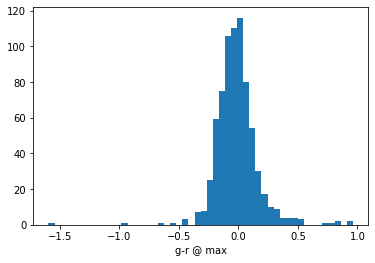

In [23]:
fig, ax = plt.subplots()
ax.hist(SNe.g_r_max, bins=50)
ax.set_xlabel("g-r @ max")

We also show the histograms of image difference number of detections.

Text(0.5, 0, 'Number of detections')

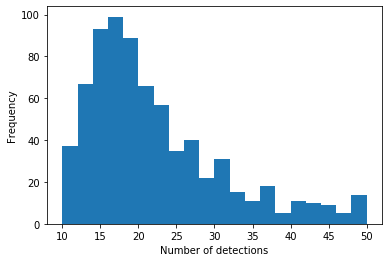

In [24]:
fig, ax = plt.subplots()
SNe.ndet.plot.hist(ax=ax, label="ndet", bins=20)
ax.set_xlabel("Number of detections")

Finall, we try some random SNe from the selected sample. Most likely, none of them will have a redshift.

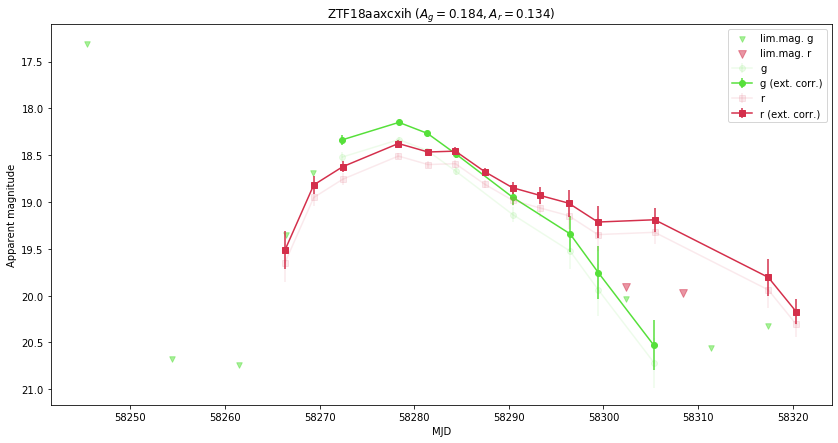

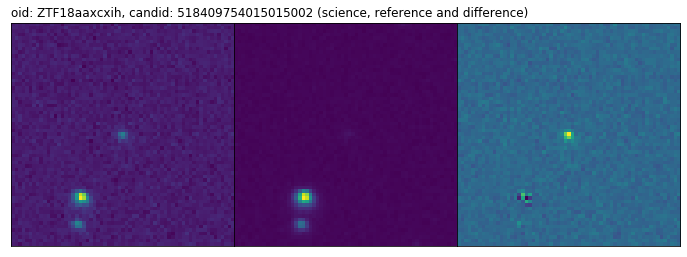

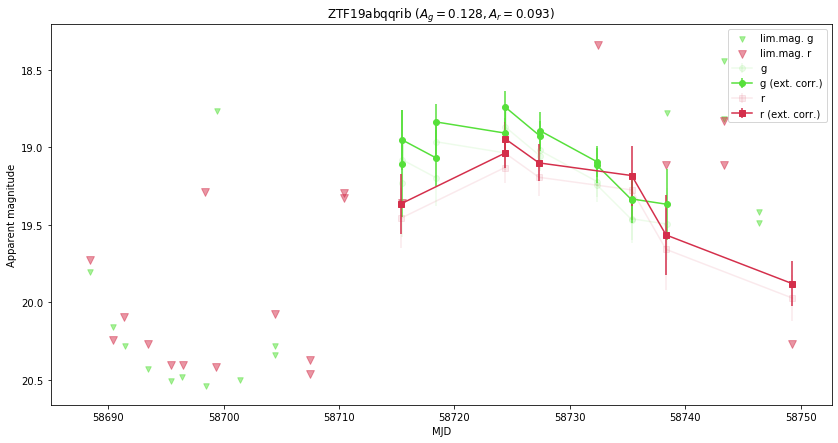

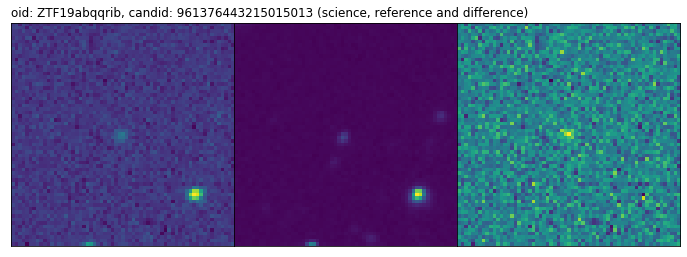

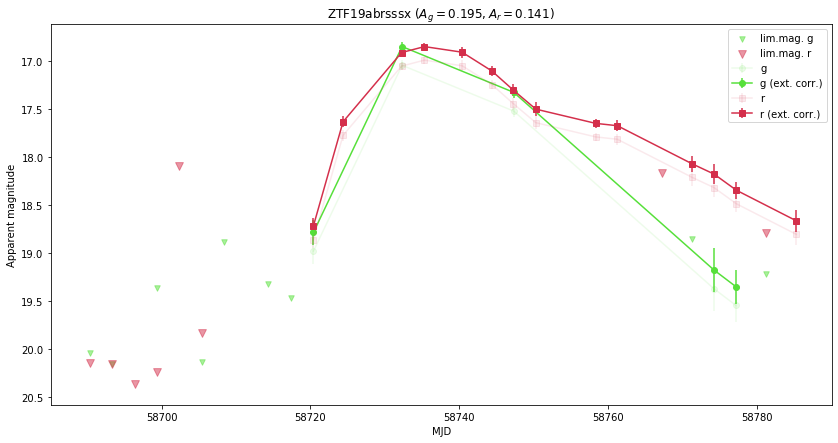

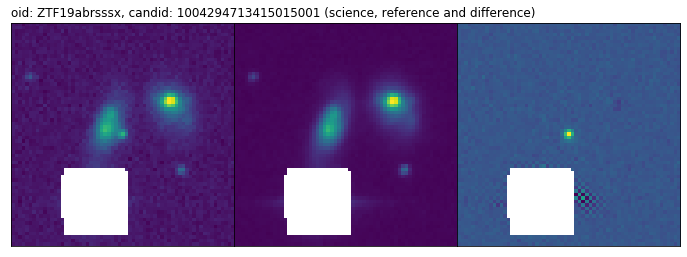

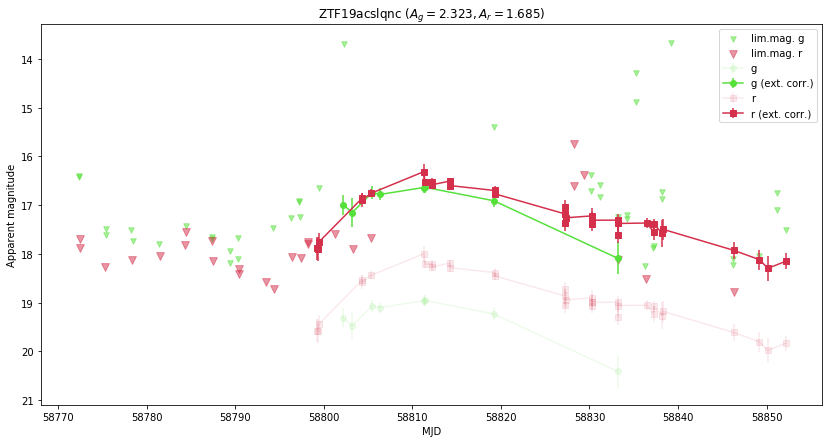

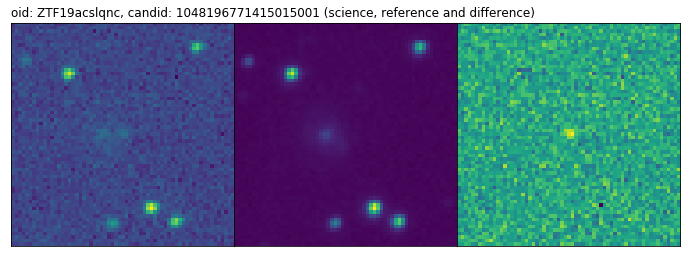

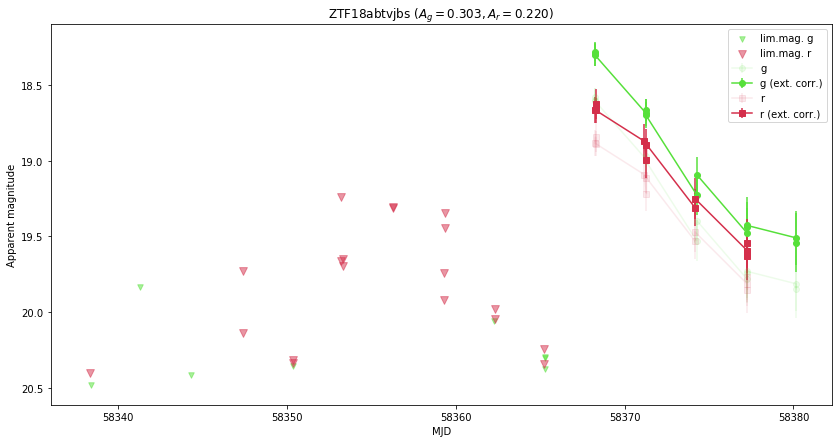

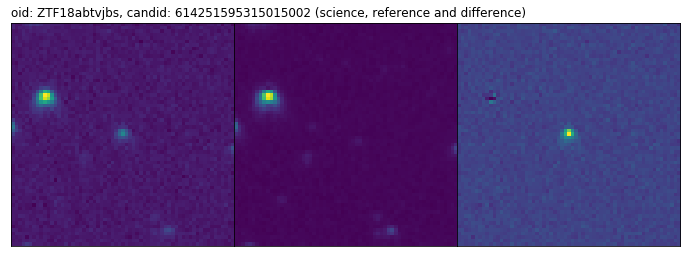

In [25]:
for oid in np.random.choice(SNe.index, size=5):
    getSNdata(oid, doLC = True, doext=True, dostamp=True, doNED=False, doredshift=True);

# Query SN candidates using a direct DB connection <a class="anchor" id="sneiadb"></a>

The previous way of querying candidates is good for relatively simple queries. However, if we want to do more complex queries the best solution may be to connect directly to the DB. We show how to do this here with different SN related use cases.

In this section you will query the tables:
* `object`: filter and bandpass aggregated properties per object
* `probability`: classification probabilities
* `magstat`: time aggregated bandpass dependent properties per object
* `ps1_ztf`: closest PanSTARRS xmatch properties (within 2")
* `detection`: individual detections, time and bandpass disaggregated
* `feature`: advanced object features, used for machine learning classification
* `non_detection`: limiting magnitudes in previous observations, the largest table of all

First, you need to install and import pyscopg2

In [26]:
#!pip install psycopg2-binary
import psycopg2

Then, you will need to use the read only credentials available in the repository

In [27]:
import json
credentials_file = "../alercereaduser_v3.json"
with open(credentials_file) as jsonfile:
    params = json.load(jsonfile)["params"]

Now we open a connection to the DB

In [28]:
conn = psycopg2.connect(dbname=params['dbname'], user=params['user'], host=params['host'], password=params['password'])

And we show all the available tables

In [29]:
query = "select tablename from pg_tables where schemaname='public';"
tables = pd.read_sql_query(query, conn)
tables.sort_values(by="tablename")

,tablename
15,allwise
13,dataquality
12,detection
1,feature
4,gaia_ztf
6,magstat
0,non_detection
2,object
7,pipeline
10,probability


You can see all the tables used in the new version of our database. The most relevant tables are, moving from less to more aggregation:

* `non_detection`: one row per non-detection per object, the limiting magnitudes
* `detection`: one row per detection, light curves and other relevant time dependent information
* `data_quality`: one row per detection, data quality related time dependent information
* `magstat`: one row per object per filter, statistics per bandpass per object
* `object`: one row per object, basic object statistics
* `probability`: one row per object per classifier and class, the probabilities of every object
* `reference`: one row per object per reference image, object statistics for every reference image used
* `feature`: one row per object per feature, object computed features
* `xmatch`: one row per object per external catalog, the table that points to the detailed xmatch tables
* `allwise, ps1_ztf, gaia_ztf, ss_stf`: one row per object, xmatch tables


For completeness, we now show all columns available in all tables!

In [30]:
alltabs = []
for tab in sorted(tables.tablename):
    cols = pd.DataFrame()
    query = "select column_name, data_type from information_schema.columns where table_name = '%s';" % tab
    results = pd.read_sql_query(query, conn)
    results["table"] = tab
    alltabs.append(results)
dftab = pd.concat(alltabs)
pd.options.display.max_rows = 999
display(dftab[["table", "column_name", "data_type"]])
pd.options.display.max_rows = 101

,table,column_name,data_type
0,allwise,k_msig_2mass,double precision
1,allwise,ra,double precision
2,allwise,dec,double precision
3,allwise,w1mpro,double precision
4,allwise,w2mpro,double precision
5,allwise,w3mpro,double precision
6,allwise,w4mpro,double precision
7,allwise,w1sigmpro,double precision
8,allwise,w2sigmpro,double precision
9,allwise,w3sigmpro,double precision


### Object and probability tables

Now we can do a query asking for SN candidates. For this it is important to understand the probability table. This table contains all the classifications probabilities, for every object, every classifier, and every available class. An object will be in many rows of this table, with the idea of being flexible to future changes in the taxonomy. 

For example, an object classified by the light curve classifier (classifier_name=lc_classifier) will appear in all the available classes, e.g., class_name='SNIa' or class_name='AGN', independently of whether this is the most likely class. The most likely class can be quickly obtained with the ranking column (ranking=1). For example, if we want to find the probabilities of the objects most likely to be RR Lyrae, we would look for objects with classifier_name='lc_classifier', class_name='RRL' and ranking=1. The probabilities will be given by the probability column. 

Now, we will query objects that are most likely to be SNe (ranking=1 among classes SNIa, SNII, SNIbc, SLSN) with a probability larger than 0.2. For this we will do a complex query, including an inner join between object and probability and selecting those oids to be considered from probability.

In [31]:
query='''
SELECT
    object.oid, object.meanra, object.meandec, object.ndet,
    object.firstMJD, object.deltajd, object.g_r_max,
    probability.classifier_name, probability.class_name,
    probability.ranking, probability.probability
FROM
    object INNER JOIN probability
    ON object.oid=probability.oid
WHERE
    probability.classifier_name='lc_classifier'
    AND object.oid IN 
(
SELECT
    oid
FROM
    probability
WHERE
    classifier_name='lc_classifier'
    AND class_name IN ('SNIa', 'SNIbc', 'SNII', 'SLSN')
    AND ranking=1
    AND probability > 0.2
)
'''

SNe = pd.read_sql_query(query, conn)
print(SNe.shape)
SNe.set_index('oid', inplace=True)
SNe.head()

(97245, 11)


,meanra,meandec,ndet,firstmjd,deltajd,g_r_max,classifier_name,class_name,ranking,probability
oid,,,,,,,,,,
ZTF20aadceoq,230.800979,80.629376,16,58852.531875,22.977303,-0.472897,lc_classifier,AGN,6,0.045760
ZTF20aadceoq,230.800979,80.629376,16,58852.531875,22.977303,-0.472897,lc_classifier,Blazar,5,0.064768
ZTF20aadceoq,230.800979,80.629376,16,58852.531875,22.977303,-0.472897,lc_classifier,CEP,14,0.003600
ZTF20aadceoq,230.800979,80.629376,16,58852.531875,22.977303,-0.472897,lc_classifier,CV/Nova,7,0.025696
ZTF20aadceoq,230.800979,80.629376,16,58852.531875,22.977303,-0.472897,lc_classifier,DSCT,15,0.002808


Let's look at all the appearances of the first SN above

In [44]:
SNe.loc[SNe.iloc[[0]].index]

,meanra,meandec,ndet,firstmjd,deltajd,g_r_max,classifier_name,class_name,ranking,probability
oid,,,,,,,,,,
ZTF20aadceoq,230.800979,80.629376,16,58852.531875,22.977303,-0.472897,lc_classifier,AGN,6,0.045760
ZTF20aadceoq,230.800979,80.629376,16,58852.531875,22.977303,-0.472897,lc_classifier,Blazar,5,0.064768
ZTF20aadceoq,230.800979,80.629376,16,58852.531875,22.977303,-0.472897,lc_classifier,CEP,14,0.003600
ZTF20aadceoq,230.800979,80.629376,16,58852.531875,22.977303,-0.472897,lc_classifier,CV/Nova,7,0.025696
ZTF20aadceoq,230.800979,80.629376,16,58852.531875,22.977303,-0.472897,lc_classifier,DSCT,15,0.002808
ZTF20aadceoq,230.800979,80.629376,16,58852.531875,22.977303,-0.472897,lc_classifier,E,12,0.007272
ZTF20aadceoq,230.800979,80.629376,16,58852.531875,22.977303,-0.472897,lc_classifier,LPV,11,0.008568
ZTF20aadceoq,230.800979,80.629376,16,58852.531875,22.977303,-0.472897,lc_classifier,Periodic-Other,10,0.009288
ZTF20aadceoq,230.800979,80.629376,16,58852.531875,22.977303,-0.472897,lc_classifier,QSO,8,0.020768


We will create a short function to convert the probabilities and rankings into columns, with one row per object. Note that this will take some time for the SN classes, so it will take much more time for othe variability classes!

In [45]:
def merge_probs(df):
    dfnew = df.copy().iloc[[0]].drop(["class_name", "ranking", "probability"], axis=1)
    for cl in df.class_name.unique():
        mask = df.class_name == cl
        dfnew["%s_prob" % cl] = df.loc[mask].probability
        dfnew["%s_rank" % cl] = df.loc[mask].ranking
    return dfnew

Let's test it with the same SN

In [46]:
merge_probs(SNe.loc[SNe.iloc[[0]].index])

,meanra,meandec,ndet,firstmjd,deltajd,g_r_max,classifier_name,AGN_prob,AGN_rank,Blazar_prob,...,SLSN_prob,SLSN_rank,SNII_prob,SNII_rank,SNIa_prob,SNIa_rank,SNIbc_prob,SNIbc_rank,YSO_prob,YSO_rank
oid,,,,,,,,,,,,,,,,,,,,,
ZTF20aadceoq,230.800979,80.629376,16,58852.531875,22.977303,-0.472897,lc_classifier,0.04576,6,0.064768,...,0.121352,4,0.151296,3,0.280528,1,0.234824,2,0.019008,9


You coud apply it to the entire dataframe, but it can take too long, so we leave it commented...

In [47]:
#SNprobs = SNe.groupby("oid").apply(merge_probs)
#SNprobs.reset_index(level=1, drop=True, inplace=True)
#SNprobs.head()

Let's look at the distribution of SNII probabilities for the objects most likely to be SNII.

Text(0.5, 0, 'SNII prob')

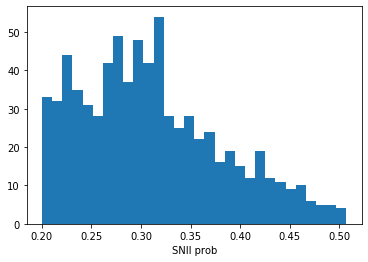

In [48]:
fig, ax = plt.subplots()
mask = (SNe.ranking == 1) & (SNe.class_name == "SNII")
ax.hist(SNe.loc[mask].probability, bins=30)
ax.set_xlabel("SNII prob")

Now we will focus on objects whose SN II probability is the 1st or 2nd most likely value. Let's compare their probabilities with SN Ia probabilities.

Text(0, 0.5, 'SNIa prob')

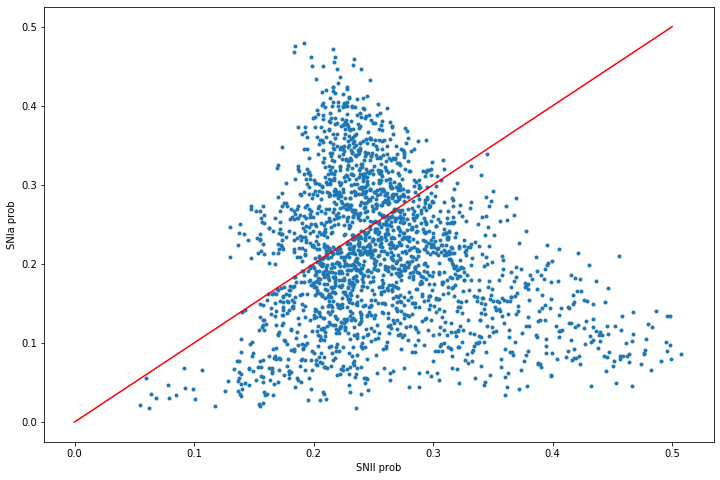

In [49]:
fig, ax = plt.subplots(figsize=(12, 8))
maskII = SNe.ranking.isin([1, 2]) & (SNe.class_name == 'SNII') # objects whose first or second most likely class is SNe II
oidII = SNe.loc[maskII].index  # create indices array to ensure same order is used for plotting
maskIa = SNe.index.isin(oidII) & (SNe.class_name == "SNIa") # SNe Ia probabilities for the previous objects


ax.scatter(SNe.loc[maskII].loc[oidII].probability, SNe.loc[maskIa].loc[oidII].probability, marker='.')
ax.plot([0, 0.5], [0, 0.5], c='r')
ax.set_xlabel("SNII prob")
ax.set_ylabel("SNIa prob")

Note that we only show objects which are classified as SNIa across the boundary, which explains the discontinuity.
Let's compare SN II and SN Ibc probabilities.

Text(0, 0.5, 'SNIbc prob')

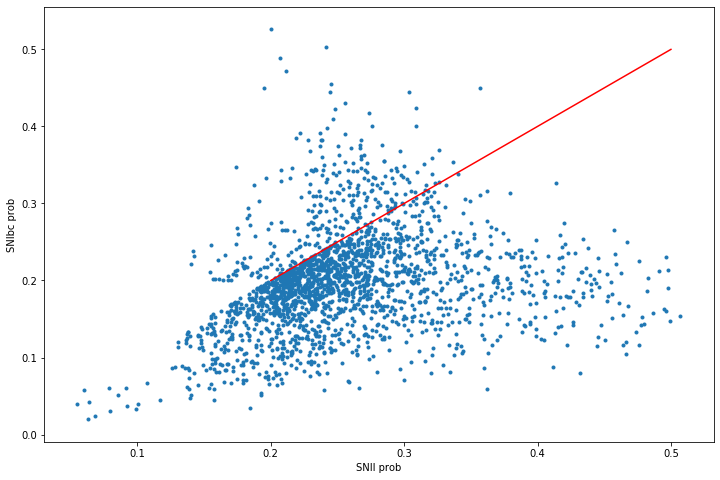

In [50]:
fig, ax = plt.subplots(figsize=(12, 8))
maskII = SNe.ranking.isin([1, 2]) & (SNe.class_name == 'SNII') # objects whose first or second most likely class is SNe II
oidII = SNe.loc[maskII].index # create indices array to ensure same order is used for plotting
maskIbc = SNe.index.isin(oidII) & (SNe.class_name == "SNIbc") # SNe Ibc probabilities for the previous objects

ax.scatter(SNe.loc[maskII].loc[oidII].probability, SNe.loc[maskIbc].loc[oidII].probability, marker='.')
ax.plot([0.2, 0.5], [0.2, 0.5], c='r')
ax.set_xlabel("SNII prob")
ax.set_ylabel("SNIbc prob")

Here the discontinuity is even stronger, because there are fewer events classified as SN Ibc accross the boundary.

Now let's compare the light curve lengths of SN II and SN Ia, which should the most obvious difference between SNe II and SNe Ia

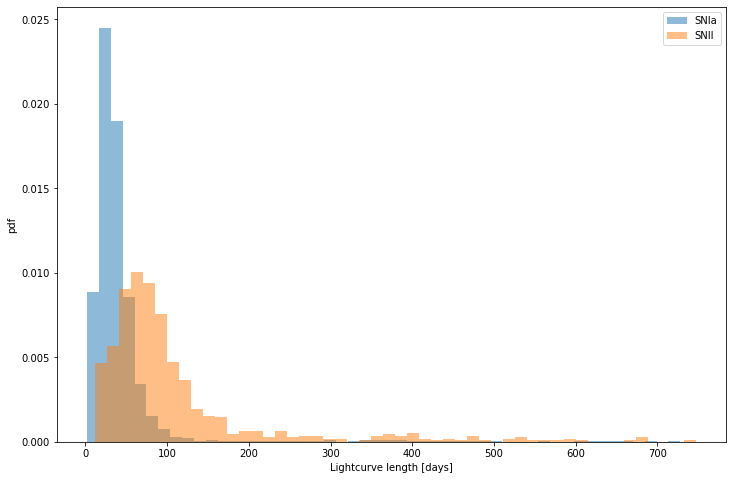

In [51]:
fig, ax = plt.subplots(figsize=(12, 8))
for idx, sn in enumerate(["SNIa", "SNII"]):
    mask = (SNe.ranking == 1) & (SNe.class_name == sn)
    ax.hist(SNe.loc[mask].deltajd, bins=50, label=sn, alpha=0.5, density=True)
ax.set_xlabel("Lightcurve length [days]")
ax.set_ylabel("pdf")
ax.legend()

We confirm that SNe II are longer lived than SNe Ia, but there are a few very long light curves.

### Magstat table

Let's now compare the peak magnitudes from SNe Ia and SNe II. Since these are statistics per band we need to access the table magstat:

In [52]:
query = '''
SELECT
    *
FROM
    magstat
WHERE
    oid in (%s)
''' % ",".join(["'%s'" % oid for oid in SNe.loc[(SNe.ranking == 1)].index.unique()])
magstats = pd.read_sql_query(query, conn)
magstats.set_index("oid", inplace=True)
magstats.head()

,fid,stellar,corrected,ndet,ndubious,dmdt_first,dm_first,sigmadm_first,dt_first,magmean,...,magmean_corr,magmedian_corr,magmax_corr,magmin_corr,magsigma_corr,maglast_corr,magfirst_corr,firstmjd,lastmjd,step_id_corr
oid,,,,,,,,,,,,,,,,,,,,,
ZTF17aaaadqv,1,False,False,14,0,-1.195096,-1.254379,-20.694881,0.971771,19.523272,...,NaN,NaN,NaN,NaN,None,NaN,NaN,58378.465,58704.445,corr_bulk_0.0.1
ZTF17aaaadqv,2,False,False,15,0,-1.256453,-1.325678,-20.402970,0.956539,19.165396,...,NaN,NaN,NaN,NaN,None,NaN,NaN,58378.426,58704.492,corr_bulk_0.0.1
ZTF17aaachlp,1,True,True,5,0,0.013396,0.008900,-20.273565,24.966007,20.355420,...,19.918420,19.829931,20.127760,19.768143,None,19.768143,20.087260,58892.164,58906.133,corr_bulk_0.0.1
ZTF17aaachlp,2,True,True,6,0,-0.195112,-1.055424,-19.529627,4.958947,19.148855,...,18.875818,18.918280,19.306679,18.401789,None,19.047000,18.401789,58895.105,58915.113,corr_bulk_0.0.1
ZTF17aaaeihd,1,True,True,6,0,-0.347215,-1.782375,-20.291426,4.908194,17.365755,...,16.836983,17.127317,17.597769,15.835422,None,15.846457,17.597769,58811.094,58814.120,corr_bulk_0.0.1


Let's show all the available columns:

In [53]:
", ".join(list(magstats))

'fid, stellar, corrected, ndet, ndubious, dmdt_first, dm_first, sigmadm_first, dt_first, magmean, magmedian, magmax, magmin, magsigma, maglast, magfirst, magmean_corr, magmedian_corr, magmax_corr, magmin_corr, magsigma_corr, maglast_corr, magfirst_corr, firstmjd, lastmjd, step_id_corr'

We will investigate magmin per band:

(21.04116765022075, 10.824605349779247)

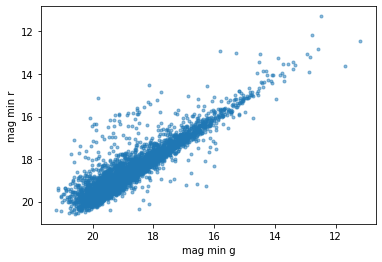

In [54]:
fig, ax = plt.subplots()   
# first, we select the object ids of objects with g band information
oidg = magstats.loc[(magstats.fid == 1)].index
# then, we select objects which are among the previous objects and which have r band information as well
oidgr = magstats.loc[(magstats.fid == 2) & magstats.index.isin(oidg)].index
# now we plot them selecting the g and r bands
ax.scatter(magstats.loc[magstats.fid == 1].loc[oidgr].magmin, magstats.loc[magstats.fid == 2].loc[oidgr].magmin, marker='.', alpha=0.5)
ax.set_xlabel("mag min g")
ax.set_ylabel("mag min r")
ax.set_xlim(ax.get_xlim()[::-1])
ax.set_ylim(ax.get_ylim()[::-1])

Another interesting property stored in magstat is the initial rise from the previous detection. This can be used to detect fast rising SNe. Let's plot those objects with large dmdt_first and whose dt_first is not too small (this can lead to divergences).

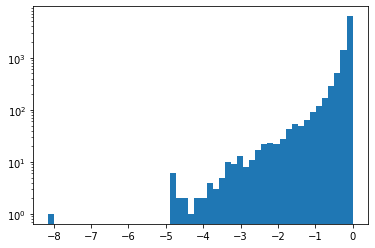

In [55]:
fig, ax = plt.subplots()
ax.hist(magstats.loc[(magstats.dt_first > 0.5) & (magstats.dmdt_first < 0)].dmdt_first, bins=50, log=True);

You can see that there are a few objects which rise very fast, let's look at the fastest objects which are very likely SNII, known to rise very fast after due to the prevalence of wind shock breakouts (see e.g. [Förster et al. 2018](https://ui.adsabs.harvard.edu/abs/2018NatAs...2..808F/abstract)):

In [57]:
seloids = magstats.loc[(magstats.dt_first > 0.5) & (magstats.dmdt_first < 0)].index # first get indices sorted by oid
seloids = SNe.loc[SNe.index.isin(seloids) & (SNe.class_name == "SNII") & (SNe.probability > 0.4)].index
seloids = magstats.loc[seloids].sort_values("dmdt_first").index.unique()[:6]
for oid in seloids:
    display(magstats.loc[oid][["dmdt_first", "fid"]])
    alerceonline = "http://dev.alerce.online.s3-website-us-east-1.amazonaws.com/object"
    display(HTML("<a href='%s/%s' target=\"_blank\"> %s <a>" % (alerceonline, oid, oid)))

,dmdt_first,fid
oid,,
ZTF20aapycrh,-1.539301,1
ZTF20aapycrh,-0.501823,2


,dmdt_first,fid
oid,,
ZTF19abajxet,-1.148545,1
ZTF19abajxet,-1.185542,2


,dmdt_first,fid
oid,,
ZTF19abqhobb,-0.993216,1
ZTF19abqhobb,-0.558308,2


,dmdt_first,fid
oid,,
ZTF18abokyfk,-0.871516,1
ZTF18abokyfk,-0.693790,2


,dmdt_first,fid
oid,,
ZTF18acqwdla,-0.693519,1
ZTF18acqwdla,-0.861135,2


,dmdt_first,fid
oid,,
ZTF19aaydtur,-0.748198,1
ZTF19aaydtur,-0.259286,2


You can explore each object and check whether these are very fast rising SNe II!

Note: there is a known bug which gives wrong values sometimes, this table is being recomputed now...

### Detection table

Let's query the light curves of objects most likely to be SNe II by accessing the detection table.

In [110]:
mask = (SNe.ranking == 1) & (SNe.class_name == "SNII")

query='''
SELECT
    oid, candid, mjd, fid, magpsf, sigmapsf, magpsf_corr, sigmapsf_corr, has_stamp
FROM
    detection
WHERE
    oid in (%s)
''' % ",".join(["'%s'" % oid for oid in SNe.loc[mask].index])
all_detections = pd.read_sql_query(query, conn)
all_detections.set_index(['candid'], inplace=True)
print(all_detections.shape)
all_detections.head()

(29334, 8)


,oid,mjd,fid,magpsf,sigmapsf,magpsf_corr,sigmapsf_corr,has_stamp
candid,,,,,,,,
1129287020415015017,ZTF18aaaibml,58883.287026,2,18.734570,0.129401,16.664377,100.0,True
1129398460415015014,ZTF18aaaibml,58883.398461,1,18.405918,0.125525,16.838608,100.0,True
1132272730415015010,ZTF18aaaibml,58886.272732,2,18.291767,0.075428,16.586044,100.0,True
1137232030415015008,ZTF18aaaibml,58891.232037,1,18.304905,0.073826,16.813898,100.0,True
1137308290415015017,ZTF18aaaibml,58891.308299,2,18.262360,0.076091,16.579866,100.0,True


Note that we use groupby to plot the light curves of each SN separated by filter id

Text(0, 0.5, 'mag')

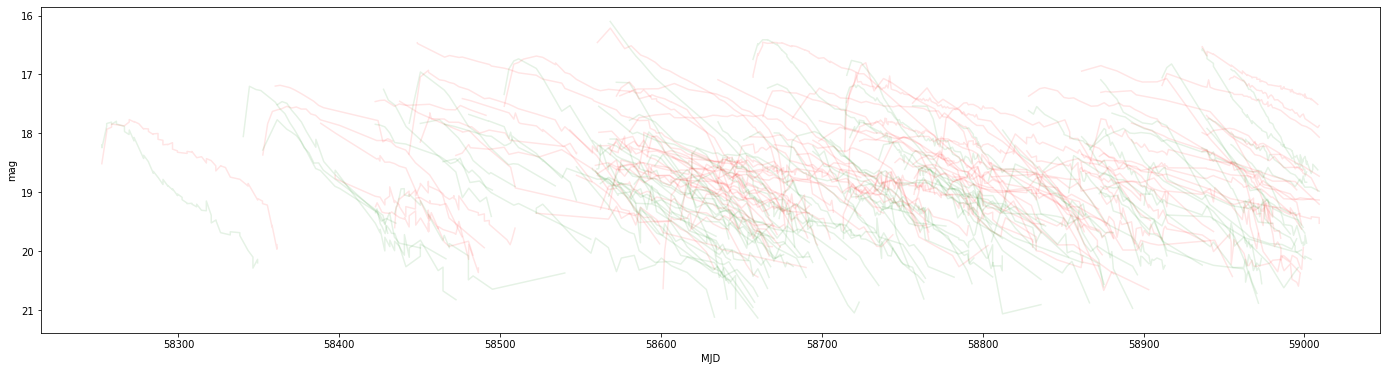

In [111]:
mask = all_detections.oid.isin(SNe.loc[(SNe.class_name == "SNII") & (SNe.probability > 0.4)].index)
def plotobject(df):
    df.groupby(["fid"]).apply(
        lambda df: 
        ax.plot(df.mjd, df.magpsf, alpha=0.1, c='g' if df.fid.unique()==1 else 'r'))
fig, ax = plt.subplots(figsize=(24, 6))
all_detections.loc[mask].groupby(["oid"]).apply(plotobject)
ax.set_ylim(ax.get_ylim()[::-1])
ax.set_xlabel("MJD")
ax.set_ylabel("mag")

These light curves seem to be OK, with a faster decline in g band followed by a more prominent plateau in r band

We will now compare SNe Ia and SNe Ibc, the two most difficult classes to separate.

Text(0, 0.5, 'SNIbc prob')

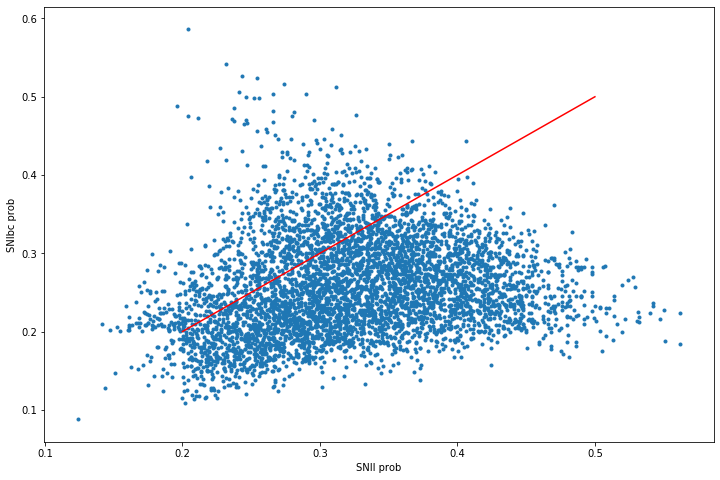

In [112]:
fig, ax = plt.subplots(figsize=(12, 8))
maskIa = SNe.ranking.isin([1, 2]) & (SNe.class_name == 'SNIa') # objects whose first or second most likely class is SNe II
oidIa = SNe.loc[maskIa].index # create indices array to ensure same order is used for plotting
maskIbc = SNe.index.isin(oidIa) & (SNe.class_name == "SNIbc") # SNe Ibc probabilities for the previous objects

ax.scatter(SNe.loc[maskIa].loc[oidIa].probability, SNe.loc[maskIbc].loc[oidIa].probability, marker='.')
ax.plot([0.2, 0.5], [0.2, 0.5], c='r')
ax.set_xlabel("SNII prob")
ax.set_ylabel("SNIbc prob")

You can see that the separation between classes is not very clear, there are many objects near the frontier where one or the other class dominates the probability. This is due to the small size of the training set and the inherent difficulty of separating SNe Ia from SNe Ibc  using apparent magnitudes only. Physically, this is because the physical process driving their light curves is the same, the diffusion of the energy deposited by 56Ni in an expanding ejecta, a process which is mainly controlled by the mass of the ejecta. 

Now we will show the histograms of light curve durations of those SNe more likely to be SNe Ia or SNe Ibc. Since SNe Ibc progenitors tend to be more massive at explosion they should have slightly longer light curves.

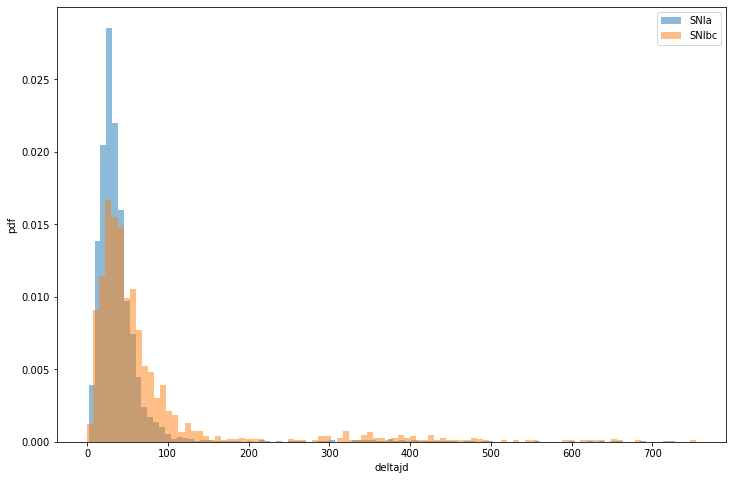

In [113]:
fig, ax = plt.subplots(figsize=(12, 8))
for idx, sn in enumerate(["SNIa", "SNIbc"]):
    mask = (SNe.class_name == sn) & (SNe.ranking == 1)
    ax.hist(SNe.loc[mask].deltajd, bins=100, label=sn, alpha=0.5, density=True)
ax.set_xlabel("deltajd")
ax.set_ylabel("pdf")
ax.legend()        

We confirm that SNe Ibc light curves are slightly longer, although there are some very long SNe Ibc, probably misclassifications.
Another expected difference is that SNe Ibc are slightly redder. Let's compare their colors.

/home/fforster/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/fforster/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


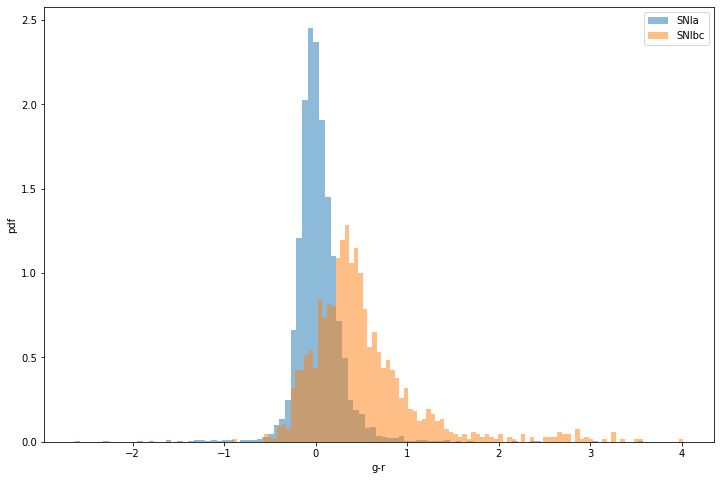

In [114]:
fig, ax = plt.subplots(figsize=(12, 8))
for idx, sn in enumerate(["SNIa", "SNIbc"]):
    mask = (SNe.class_name == sn) & (SNe.ranking == 1)
    ax.hist(SNe.loc[mask].g_r_max, bins=100, label=sn, alpha=0.5, density=True)
ax.set_xlabel("g-r")
ax.set_ylabel("pdf")
ax.legend()        

We confirm that SNe Ibc g-r colors are redder at maximum.

### PS1 table
Let's get some host galaxy information based on the closest PanSTARRS source

In [115]:
query='''
SELECT
    oid, sgmag1, srmag1, simag1, szmag1, sgscore1
FROM
    ps1_ztf
WHERE
    oid in (%s)
''' % ",".join(["'%s'" % oid for oid in SNe.index.unique()])
ps1 = pd.read_sql_query(query, conn)
ps1.set_index("oid", inplace=True)
ps1.head()

,sgmag1,srmag1,simag1,szmag1,sgscore1
oid,,,,,
ZTF17aaaadqv,-999.0000,19.3744,19.2422,18.7527,0.318000
ZTF17aaachlp,21.2108,19.4429,18.9659,18.7912,0.805714
ZTF17aaaeihd,18.1066,17.2023,16.7179,16.4385,0.992500
ZTF17aaagpwv,21.9000,21.3638,20.9285,20.2765,0.195979
ZTF17aaaumzf,21.9000,21.3638,20.9285,20.2765,0.195979


In [116]:
ps1["g_r_host"] = ps1.sgmag1 - ps1.srmag1
ps1["r_i_host"] = ps1.srmag1 - ps1.simag1
ps1["sgscore1"] = ps1.sgscore1

We make a cut on galaxy classified sources, non zero colors, and relatively small absolute values. We plot their cumulative distributions and do KS tests.

Text(0.5, 0, 'Host r-i')

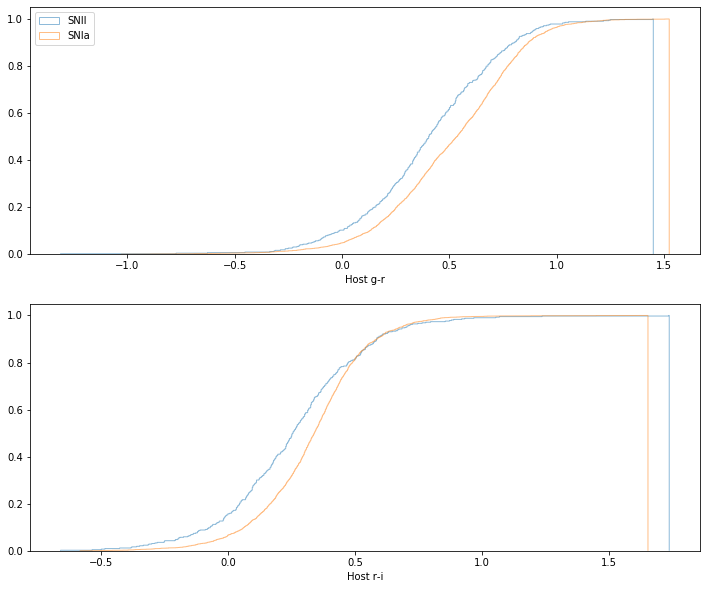

In [117]:
from scipy import stats
fig, ax = plt.subplots(nrows=2, figsize=(12, 10))
mask_host = (ps1.sgscore1 < 0.5) & (ps1.g_r_host.abs() > 0) & (ps1.g_r_host.abs() < 2) & (ps1.r_i_host.abs() > 0) & (ps1.r_i_host.abs() < 2)
for sn in ["SNII", "SNIa"]:
    mask_sn = (SNe.class_name == sn) & (SNe.ranking == 1)
    oid_sn = SNe.loc[mask_sn].index
    mask = mask_host & ps1.index.isin(oid_sn)
    oid = ps1.loc[mask].index
    ax[0].hist(ps1.loc[mask].g_r_host, label=sn, bins=1000, alpha=0.5, cumulative=True, density=True, histtype='step')
    ax[1].hist(ps1.loc[mask].r_i_host, label=sn, bins=1000, alpha=0.5, cumulative=True, density=True, histtype='step')
ax[0].legend()
ax[0].set_xlabel("Host g-r")
ax[1].set_xlabel("Host r-i")

We can see that SNe Ia tend to live in redder galaxies than SNe II, which is consistent with them being associated to older progenitors.

We will now query and plot the light cuves of objects those more likely to be SNe Ia

In [118]:
mask = SNe.class_name.isin(["SNIa", "SNIbc", "SNII", "SLSN"]) & (SNe.ranking == 1)

query='''
SELECT
    oid, candid, mjd, fid, magpsf, sigmapsf, magpsf_corr, sigmapsf_corr, has_stamp
FROM
    detection
WHERE
    oid in (%s)
''' % ",".join(["'%s'" % oid for oid in SNe.loc[mask].index])
all_detections = pd.read_sql_query(query, conn)
all_detections.set_index(['candid'], inplace=True)
all_detections.head()

,oid,mjd,fid,magpsf,sigmapsf,magpsf_corr,sigmapsf_corr,has_stamp
candid,,,,,,,,
624426581115015074,ZTF17aaaadqv,58378.426586,2,19.201122,0.123831,NaN,NaN,True
624463701115015007,ZTF17aaaadqv,58378.463704,1,19.533522,0.093020,NaN,NaN,True
625473001115015057,ZTF17aaaadqv,58379.473009,1,18.954454,0.080476,NaN,NaN,True
625513181115015031,ZTF17aaaadqv,58379.513183,2,18.518810,0.073205,NaN,NaN,True
626453721115015136,ZTF17aaaadqv,58380.453727,2,18.733690,0.073998,NaN,NaN,True


We will plot objects with a probability of being SNe Ia larger than 0.4

Text(0, 0.5, 'mag')

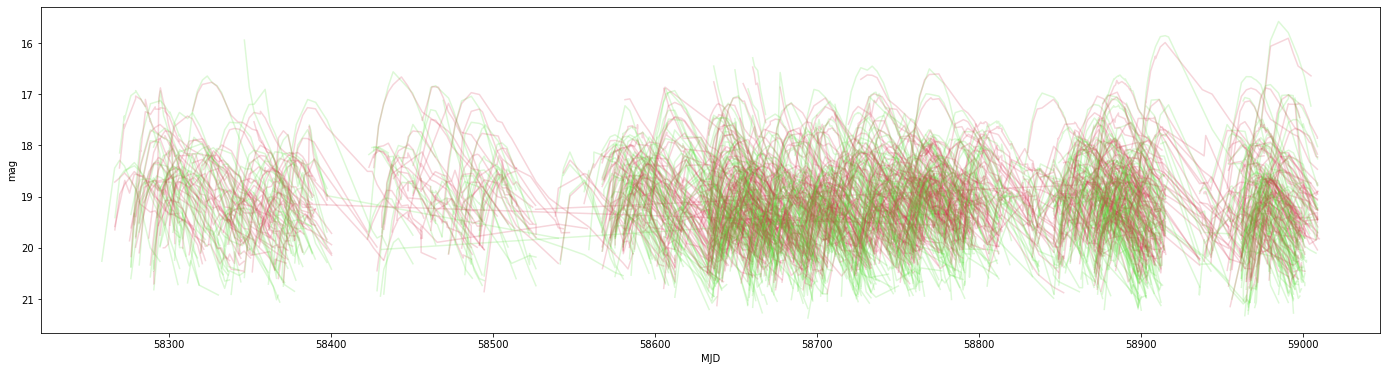

In [119]:
mask = (SNe.class_name == "SNIa") & (SNe.ranking == 1) & (SNe.probability > 0.4)
mask = all_detections.oid.isin(SNe.loc[mask].index)
def plotobject(df):
    df.groupby(["fid"]).apply(
        lambda df: 
        ax.plot(df.mjd, df.magpsf, alpha=0.2, c=colors[1] if df.fid.unique()==1 else colors[2]))
fig, ax = plt.subplots(figsize=(24, 6))
all_detections.loc[mask].groupby(["oid"]).apply(plotobject)
ax.set_ylim(ax.get_ylim()[::-1])
ax.set_xlabel("MJD")
ax.set_ylabel("mag")

Here we can see that most SN light curves look OK, although there a few which seem to be too long.

### Feature table

A family of features we compute for all objects is provided by a simple analytic SN light curve, a reparametrization of the model of [Villar et al. 2019](https://ui.adsabs.harvard.edu/abs/2019ApJ...884...83V/abstract et al. 2019) (see Sánchez-Sáez et al. 2020).

This model is the following:

$$
\Large
F = \begin{cases}
        \cfrac{A \left(1 - \beta' \frac{t - t_0}{t_1 - t_0}\right)}{1 + \exp{\left(-\frac{t - t_0}{\tau_{\rm rise}}\right)}} & \mbox{if} \; t < t_1  \\ 
        \\
        \cfrac{A (1 - \beta') \exp{\left(-\frac{t - t_1}{\tau_{\rm fall}}\right)}}{1 + \exp{\left(-\frac{t - t_0}{\tau_{\rm rise}}\right)}} & \mbox{if} \; t \ge t_1,
  \end{cases}
$$

where we measure $t_0$ w.r.t. the first dectection. We will overplot the best fitting models to get an idea of how good these fits are.

Let's query the feature names from the `feature` table to see what is available. These features start with SPM (supernova parametric models), so we will look for features starting with these three characters.

In [120]:
mask = SNe.class_name.isin(["SNIa", "SNIbc", "SNII", "SLSN"]) & (SNe.ranking == 1)
query='''
SELECT
    *
FROM
    feature
WHERE
    LEFT(name, 3)='SPM'
    AND oid in (%s)
''' % ",".join(["'%s'" % oid for oid in SNe.loc[mask].index])
features = pd.read_sql_query(query, conn)
features.head()

,oid,name,value,fid,version
0,ZTF17aaaadqv,SPM_A,0.212506,1,bulk_0.0.1
1,ZTF17aaaadqv,SPM_A,0.415650,2,bulk_0.0.1
2,ZTF17aaaadqv,SPM_beta,43.851101,1,bulk_0.0.1
3,ZTF17aaaadqv,SPM_beta,36.893188,2,bulk_0.0.1
4,ZTF17aaaadqv,SPM_chi,7.251748,1,bulk_0.0.1


You can see that each object has one row per feature per band. Let's show the unique feature names:

In [121]:
features.name.unique()

array(['SPM_A', 'SPM_beta', 'SPM_chi', 'SPM_gamma', 'SPM_t0',
       'SPM_tau_fall', 'SPM_tau_rise'], dtype=object)

Let's define a function and test it with one SN

In [122]:
def Villar_m(mjd, firstmjd, pars):
    A = pars["SPM_A"] # * 1e-26 # erg/s/Hz, note that we save 1e26 * A in cgs in the database
    t0 = pars["SPM_t0"]
    beta_m = pars["SPM_gamma"] # fix inverted values bug
    gamma = pars["SPM_beta"] # fix inverted values bug
    trise = pars["SPM_tau_rise"]
    tfall = pars["SPM_tau_fall"]
    
    # correct t0 and t1
    mjd0 = t0 + firstmjd
    mjd1 = mjd0 + gamma
    
    # mask
    mask = mjd <= mjd1

    F = np.zeros_like(mjd)
    if mask.sum() > 0:
        den = (1. + np.exp(-(mjd[mask] - mjd0) / trise))
        F[mask] = A * (1 - beta_m * (mjd[mask] - mjd0) / (mjd1 - mjd0)) / den
    if np.invert(mask).sum() > 0:
        den = (1. + np.exp(-(mjd[~mask] - mjd0) / trise))
        F[~mask] = A * ((1 - beta_m) * np.exp(-(mjd[~mask] - mjd0) / tfall)) / den
    
    return F

Let's define a function to transform fluxes into magnitudes

In [136]:
def flux2mag(flux):
    return -2.5 * np.log10(flux) + 2.5 * 26 - 48.6 # note that the factor 2.5 * 26 comes from the fact that the normalization is stored multiplied by 1e26, to take less space in our database

Now we will plot the model light curves for all the objects with probability of being SN Ia greater than 0.4

(22, 15)

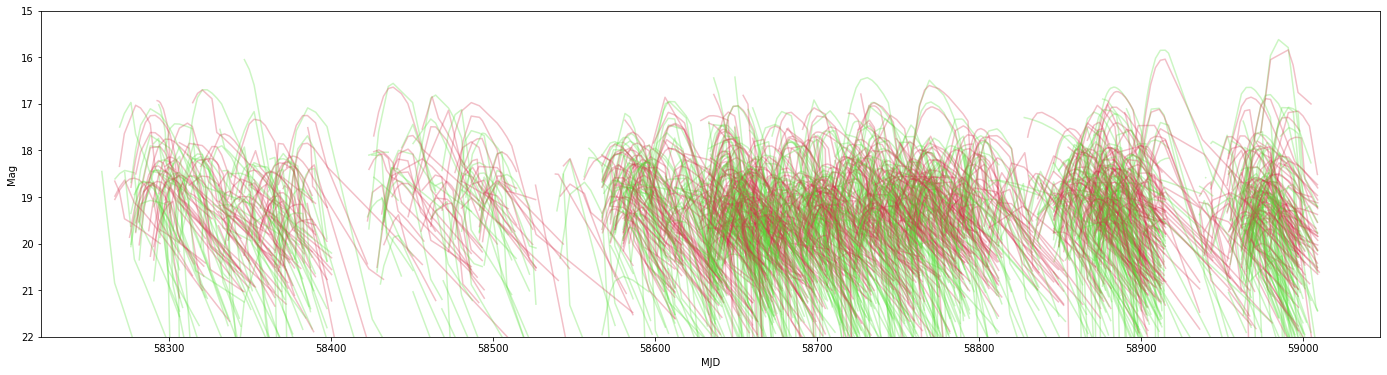

In [124]:
fig, ax = plt.subplots(figsize=(24, 6))
maskIa = (SNe.class_name == "SNIa") & (SNe.probability > 0.4)
oidIa = SNe.loc[maskIa].index
for oid in oidIa:
    
    mask_det = all_detections.oid == oid
    mask_feat = features.oid == oid
    for fid in all_detections.loc[mask_det].fid.unique():
        if fid == 3:
            continue
        mask_fid = all_detections.loc[mask_det].fid == fid
        times = all_detections.loc[mask_det].loc[mask_fid].mjd.values
        magpsf = all_detections.loc[mask_det].loc[mask_fid].magpsf.values
        mask_fid = features.loc[mask_feat].fid == fid
        vals = {}
        for val in ["SPM_A", "SPM_t0", "SPM_gamma", "SPM_beta", "SPM_tau_rise", "SPM_tau_fall"]:
            vals[val] = features.loc[mask_feat].loc[mask_fid].loc[features.loc[mask_feat].loc[mask_fid].name == val].value.values[0]
        #times = np.linspace(times.min(), times.max(), 100)
        model = Villar_m(times, SNe.loc[oid].firstmjd.iloc[0], vals)
        mask = model > 0
        ax.plot(times[mask], flux2mag(model[mask]), c=colors[fid], alpha=0.3)
    #break

ax.set_ylabel("Mag")
ax.set_xlabel("MJD")
ax.set_ylim(22, 15)

The modeled light curves look OK, note that we plotted them assuming A=1 and in flux space in order for them to be easier to visualize.

And now the SNe II candidates with probabilities greater than 0.4

(22, 15)

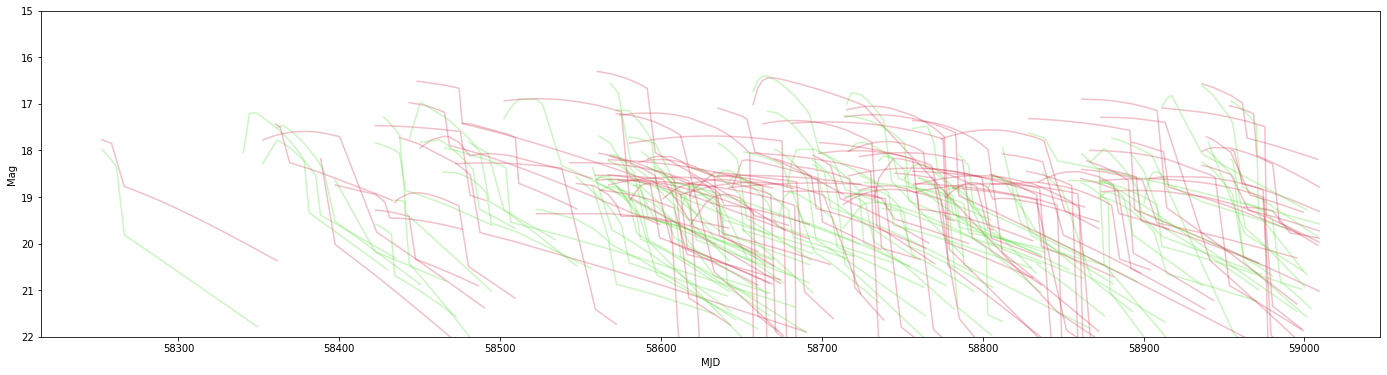

In [125]:
fig, ax = plt.subplots(figsize=(24, 6))
maskII = (SNe.class_name == "SNII") & (SNe.probability > 0.4)
oidII = SNe.loc[maskII].index
for oid in oidII:
    mask_det = all_detections.oid == oid
    mask_feat = features.oid == oid
    for fid in all_detections.loc[mask_det].fid.unique():
        if fid == 3:
            continue
        mask_fid = all_detections.loc[mask_det].fid == fid
        times = all_detections.loc[mask_det].loc[mask_fid].mjd.values
        magpsf = all_detections.loc[mask_det].loc[mask_fid].magpsf.values
        mask_fid = features.loc[mask_feat].fid == fid
        vals = {}
        for val in ["SPM_A", "SPM_t0", "SPM_gamma", "SPM_beta", "SPM_tau_rise", "SPM_tau_fall"]:
            vals[val] = features.loc[mask_feat].loc[mask_fid].loc[features.loc[mask_feat].loc[mask_fid].name == val].value.values[0]
        #times = np.linspace(times.min(), times.max(), 100)
        model = Villar_m(times, SNe.loc[oid].firstmjd.iloc[0], vals)
        mask = model > 0
        ax.plot(times[mask], flux2mag(model[mask]), c=colors[fid], alpha=0.3)
ax.set_ylabel("Mag")
ax.set_xlabel("MJD")
ax.set_ylim(22, 15)

The light curves look longer lived, although it's difficult to see the plateau. Let's compare their rise times, beta and gamma parameters.

Text(0.5, 0, 'SPM_tau_rise')

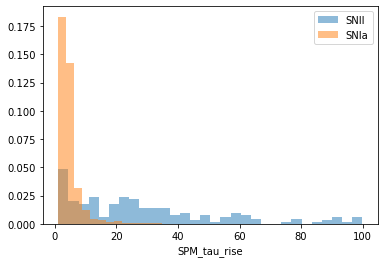

In [126]:
fig, ax = plt.subplots()
mask_feat = (features.name=="SPM_tau_rise") & features.oid.isin(SNe.loc[(SNe.class_name == "SNII") & (SNe.probability > 0.4)].index)# 
ax.hist(features.loc[mask_feat].value, label="SNII", alpha=0.5, bins=30, density=True);
mask_feat = (features.name=="SPM_tau_rise") & features.oid.isin(SNe.loc[(SNe.class_name == "SNIa") & (SNe.probability > 0.4)].index)# 
ax.hist(features.loc[mask_feat].value, label="SNIa", alpha=0.5, bins=30, density=True);
ax.legend()
ax.set_xlabel("SPM_tau_rise")

Text(0.5, 0, 'SPM_beta')

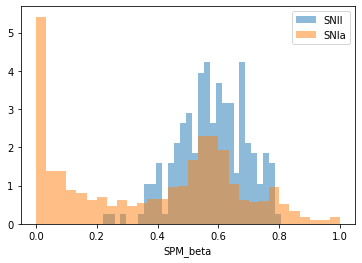

In [127]:
fig, ax = plt.subplots()
mask_feat = (features.name=="SPM_gamma") & features.oid.isin(SNe.loc[(SNe.class_name == "SNII") & (SNe.probability > 0.4)].index)# 
ax.hist(features.loc[mask_feat].value, label="SNII", alpha=0.5, bins=30, density=True);
mask_feat = (features.name=="SPM_gamma") & features.oid.isin(SNe.loc[(SNe.class_name == "SNIa") & (SNe.probability > 0.4)].index)# 
ax.hist(features.loc[mask_feat].value, label="SNIa", alpha=0.5, bins=30, density=True);
ax.legend()
ax.set_xlabel("SPM_beta") # note that SPM¡_beta and SPM_gamma are inverted in the database!

Text(0.5, 0, 'SPM_gamma')

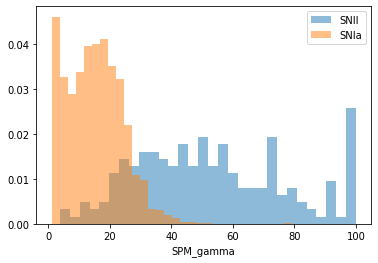

In [128]:
fig, ax = plt.subplots()
mask_feat = (features.name=="SPM_beta") & features.oid.isin(SNe.loc[(SNe.class_name == "SNII") & (SNe.probability > 0.4)].index)# 
ax.hist(features.loc[mask_feat].value, label="SNII", alpha=0.5, bins=30, density=True);
mask_feat = (features.name=="SPM_beta") & features.oid.isin(SNe.loc[(SNe.class_name == "SNIa") & (SNe.probability > 0.4)].index)# 
ax.hist(features.loc[mask_feat].value, label="SNIa", alpha=0.5, bins=30, density=True);
ax.legend()
ax.set_xlabel("SPM_gamma")

We can see that beta is much larger for SNe II, as expected.

### Non_detection table

Finally, here we show how to get all the non detections associated to the previous sample, selecting only limiting magnitude above 17 magnitudes.

In [129]:
query = '''
SELECT
    oid, fid, diffmaglim, mjd
FROM
    non_detection
WHERE
    diffmaglim > 17
    AND oid in (%s)
''' % ",".join(["'%s'" % oid for oid in SNe.loc[(SNe.class_name == "SNIa") & (SNe.ranking == 1)].index.unique()])
all_non_detections = pd.read_sql_query(query, conn)
all_non_detections.head()

,oid,fid,diffmaglim,mjd
0,ZTF17aaawhdk,2,20.1983,58628.407940
1,ZTF17aaawhdk,1,20.1862,58628.466134
2,ZTF17aaawhdk,2,20.8120,58633.426262
3,ZTF17aaawhdk,1,20.9348,58633.445856
4,ZTF17aaawhdk,1,20.1782,58634.482396


And we show the distribution of limiting magnitudes

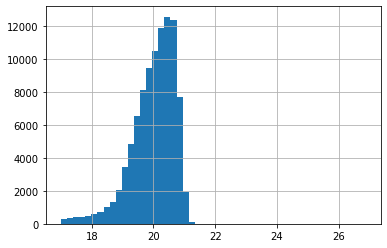

In [130]:
all_non_detections.diffmaglim.hist(bins=50)

Let's compute the moon phase at all time for the non detections

In [131]:
from astropy.time import Time

A reference time for a new moon

In [132]:
new_moon = Time("2020-07-20T13:32:00", format='isot', scale='utc')

The synodic moon period

In [133]:
moon_synodic_period = 29.53049

Apply a function which returns the moon phase

In [134]:
all_non_detections["moon_phase"] = all_non_detections.apply(lambda row: np.mod((Time(row.mjd, format='mjd') - new_moon).value, moon_synodic_period) / moon_synodic_period, axis=1)

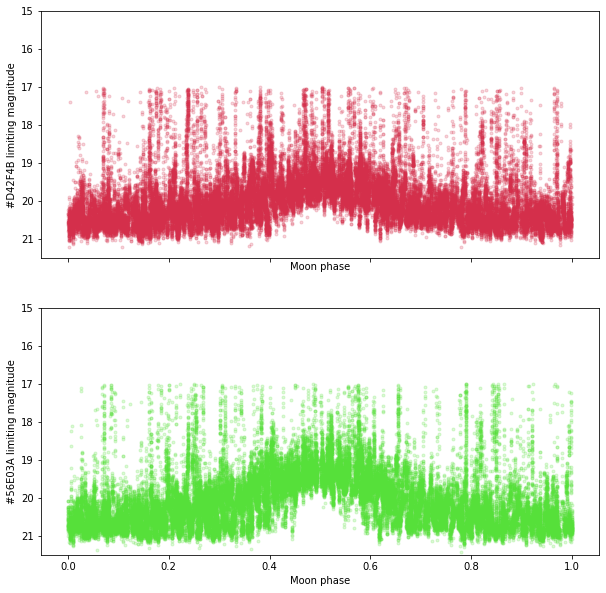

In [135]:
fig, ax = plt.subplots(nrows = 2, figsize = (10, 10), sharex = True)
for idx, fid in enumerate(all_non_detections.fid.unique()):
    if fid == 3:
        continue
    mask = all_non_detections.fid == fid
    ax[idx].scatter(all_non_detections.moon_phase.loc[mask], all_non_detections.diffmaglim.loc[mask], c=colors[fid], marker='.', alpha=0.2)
    ax[idx].set_ylim(21.5, 15)
    ax[idx].set_xlabel("Moon phase")
    ax[idx].set_ylabel("%s limiting magnitude" % colors[fid])

We can see that, as expected, limiting magnitudes are smaller close to full moon. There is a about 1.5 and 1.0 magnitudes of difference in depth between the new and full moon in the g and r bands, respectively.

### Congratulations, you made it to the end of this notebook!

### If you would like to contribute with your own notebook, please let us know!